In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hyperparameters

input_size=2 #to LSTM cell
output_size=1
hidden_size=32
num_layers=2
n_seq = 201
features = 2 

dataset shape:  (1000, 1)


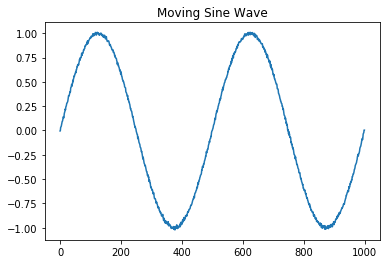

In [31]:
#Dataset

Real_Data = False

if Real_Data: #Boston daily precipitation 1950-2004
    dataset = np.load('sliced.npy')
    dataset = dataset[0:1000]
    dataset = dataset/dataset.max()
    dataset.resize(dataset.shape[0],1)
    plt.plot(dataset)
    plt.title('Daily Precipitation over Boston')
    
else: #moving sine wave
    time = np.linspace(0,4*np.pi,1000)
    dataset = np.sin(time) + 0.01*np.random.randn(1000)
    dataset.resize(dataset.shape[0],1)
    plt.plot(dataset)
    plt.title('Moving Sine Wave')
    

print('dataset shape: ', dataset.shape)

(998, 2, 1) (998, 1)
total windows:  798
(798, 201, 2)
(798, 201, 1)
(798, 1, 201, 2) (798, 1, 201, 1)
torch.Size([798, 1, 201, 2]) torch.Size([798, 1, 201, 1])


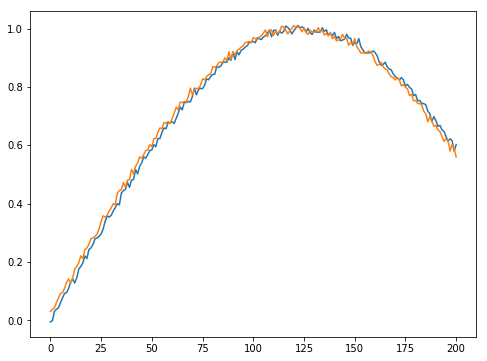

In [32]:
#Create input and label dataset

def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset, features)
print(data_X.shape, data_Y.shape)

total_length = data_X.shape[0]
sliding_windows = total_length-(n_seq-1)
print('total windows: ', sliding_windows)

temp = np.zeros((sliding_windows, n_seq,features))
temp2 = np.zeros((sliding_windows, n_seq,1))

for i in range(sliding_windows):
    temp[i,:]=data_X[i:i+n_seq,:,0]
    temp2[i,:]=data_Y[i:i+n_seq,:]

print(temp.shape)
print(temp2.shape)

xx = temp.reshape(sliding_windows, 1, n_seq, features )
yy = temp2.reshape(sliding_windows, 1, n_seq, 1 )
print(xx.shape, yy.shape)

x = torch.tensor(xx).float()
y = torch.tensor(yy).float()

print(x.shape, y.shape)
plt.figure(figsize=(8,6))
plt.plot(x[0,0,:,0].numpy())
plt.plot(y[0,0,:,0].numpy())
plt.show()

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # lstm
        self.reg = nn.Linear(hidden_size, output_size) 
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x, _ = self.lstm(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # input format converted to a linear layer
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [36]:
#Instantiate Model
model = LSTM(input_size, hidden_size, output_size, num_layers)
print(model)

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

LSTM(
  (lstm): LSTM(2, 32, num_layers=2)
  (reg): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


In [37]:
def train(model, x, y, n_steps, print_every):
    '''
    initialize the hidden state
    '''
    hidden = None      
    
    for step in range(n_steps):
        
        x_in = x[step]
        y_out = y[step]
        
        prediction = model(x_in)
        # calculate the loss
        loss = criterion(prediction, y_out[0])
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if step%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(y_out[0].data.numpy().flatten(), 'r') # input
            plt.plot(prediction.data.numpy().flatten(), 'b') # predictions
            plt.show()
    
    return model

Loss:  0.0005672546685673296


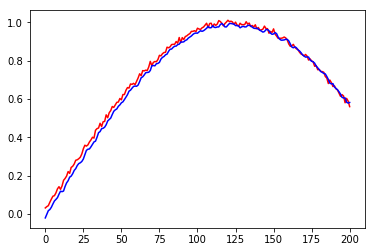

Loss:  0.00017625400505494326


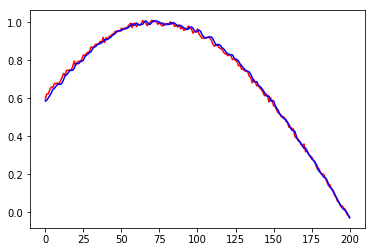

Loss:  0.00012730699381791055


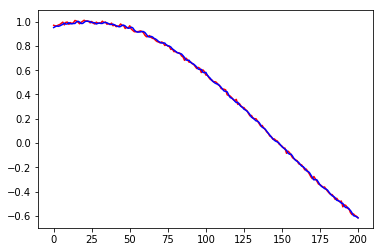

Loss:  0.0001309960789512843


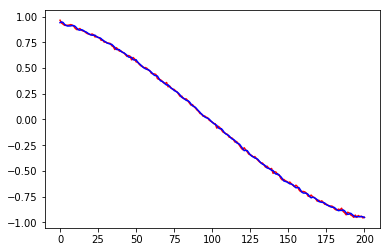

Loss:  0.00015617242024745792


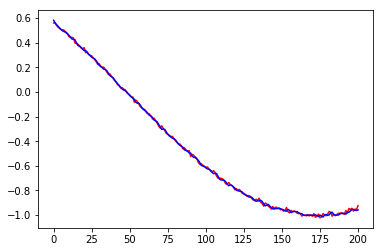

Loss:  0.0002681882760953158


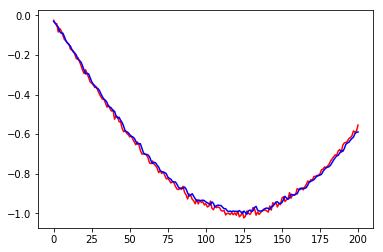

Loss:  0.00022726944007445127


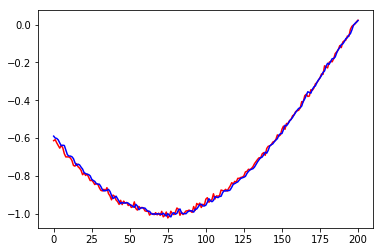

Loss:  0.00015954635455273092


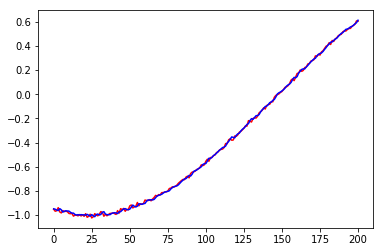

In [42]:
#Training the Model

n_train = 400 #traning datapoints to be used
print_every = 50

if n_train > x.shape[0]:
    print("Not enough data. Max available: {} datapoints".format(x.shape[0]))

else:
    trained_model = train(model, x, y, n_train, print_every)


torch.Size([398, 1, 201, 2]) torch.Size([398, 1, 201, 1])
Loss:  0.00023219207650981843


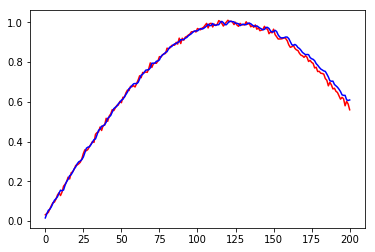

Loss:  0.000445965415565297


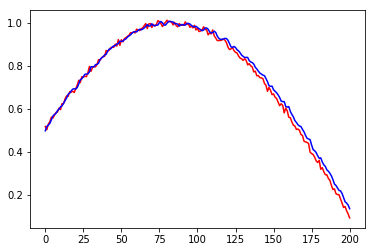

Loss:  0.0006998569588176906


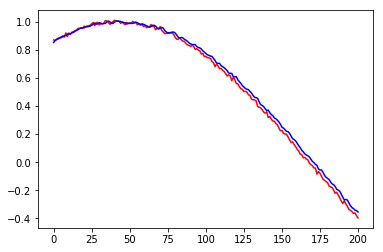

Loss:  0.0008719861507415771


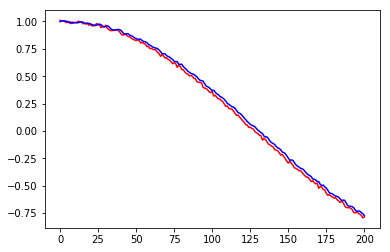

Loss:  0.0009372447966597974


In [43]:
#Test Run

with torch.no_grad():
    x_test = x[n_train:]
    y_test = y[n_train:]
    
    print(x_test.shape, y_test.shape)
   
    hidden = None
    for step in range(200):
        x_in = x[step]
        y_out = y[step]
        
        prediction = model(x_in)
        loss = criterion(prediction, y_out[0])
        
        # display loss and predictions
        if step%40 == 0:        
            print('Loss: ', loss.item())
            plt.plot(y_out[0].data.numpy().flatten(), 'r') # input
            plt.plot(prediction.data.numpy().flatten(), 'b') # predictions
            plt.show()
